# Cleaning Colic Data
A notebook to detail cleaning processes and some exploratory analysis of equine colic data, with the goal of using it to predict survival outcomes with a machine learning model.

### About the Data
The data set was created by Mary McLeish and Matt Cecile of the University of Guelph, and was downloaded from [Kaggle](https://www.kaggle.com/uciml/horse-colic). The data details diagnostic attributes of horses admitted to the veterinary hospital for colic, whether the animal was treated with surgery, and whether the animal survived.

##### Explanation of Data Columns
(This information is provided in the data dictionary, and was included for ease of access)
* `surgery` - Whether the horse was treated with surgery
* `age` - Whether the horse was an **adult** or **young** (<6 months)
* `hospital_number` - Case number assigned to horse (may repeat if multiple treatments)
* `rectal_temp` - In Celsius. May increase due to infection of lesion. May be low during late shock. Normal is 37.5
* `pulse` - In beats per minute. 30-45 is normal. Animals in pain or in shock may have elevated pulse
* `respiratory_rate` - Normally 8-10. Fluctuates greatly, doubtful if useful.
* `temp_of_extremities` - Subjective, may be **normal**, **warm**, **cool**, or **cold**. The latter two may indicate shock. "Warm" should correlate with higher `rectal_temp`
* `peripheral_pulse` - Subjective, indicates circulation. May be **normal**, **increased**, **reduced**, or **absent**
* `mucous_membrane` - Subjective, indicates circulation
| Color | Indication |
| :----- | ----------: |
| Normal pink | Normal circulation |
| Bright pink | Increased circulation |
| Pale pink | Early shock |
| Pale cyanotic | Serious circulatory compromise |
| Bright red | Septicemia |
| Dark cyanotic | Serious circulatory compromise |
* `capillary_refill_time` - Either **more** or **less** than 3 seconds. Higher values indicate poor circulation
* `pain` - Subjective, and may be affected by prior treatment. May be **alert** (no pain), **depressed**, **mild**, **severe**, or **extreme**. Generally, the more pain present, the more likely surgery is required.
* `peristalsis` - Indicates activity level in the gut. May be **hypermotile**, **normal**, **hypomotile**, or **absent**. Less activity indicates a more severe condition
* `abdominal_distention` - Important. May be **none**, **slight**, **moderate**, or **severe**. Large amounts of distention usually result in more pain and less peristalsis. Severe distention likely needs surgery to relieve pressure
* `nasogastric_tube` - Indicates how much gas is released from the stomach when a nasogastric tube is inserted. May be **none**, **slight**, or **significant**
* `nasogastric_reflux` - Indicates how much reflux comes through the nasogastric tube. May be **none**, **less than 1L**, or **more than 1L**. Presence of reflux may indicate a blockage of fluid.
* `nasogastric_reflux_ph` - pH of nasogastric reflux. Ranges from 0 to 14, with values of 3-4 as normal
* `rectal_exam_feces` - Indicates presence of feces in the rectum. May be **normal**, **increased**, **decreased**, or **absent**. Absent feces indicates an obstruction
* `abdomen` - May be **normal**, **firm** feces in large intestine, **distend_large** intestine, **distend_small** intestine, or **other**.
* `packed_cell_volume` - The number of red blood cells by volume in the blood. Normal range is 30-50. May rise as circulation is compromised or animal is dehydrated
* `total_protein` - Normal range is 6-7.5gms/dL. Increases with dehydration
* `abdomo_appearance` - Appearance of fluid taken from abdominocentesis. May be **clear**, **cloudy**, or **serosanguinous**. Normal fluid is clear
* `abdomo_protein` - The amount of protein in abdominocentesis fluid. Higher levels correlate with a more compromised gut
* `outcome` - The horse's outcome. May be **lived**, **died**, or **euthanized**
* `surgical_legion` - Whether or not the problem/lesion was surgical
* `lesion_1` - Code representing the location and type of the lesion
* `lesion_2` - as above
* `lesion_3` - as above
* `cp_data` - Whether or not pathological data was taken. This is not included

In [1]:
# Importing relevant libraries
import pandas as pd
pd.set_option('display.max_columns', 30)

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [2]:
horses = pd.read_csv('horse.csv')
horses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surgery                299 non-null    object 
 1   age                    299 non-null    object 
 2   hospital_number        299 non-null    int64  
 3   rectal_temp            239 non-null    float64
 4   pulse                  275 non-null    float64
 5   respiratory_rate       241 non-null    float64
 6   temp_of_extremities    243 non-null    object 
 7   peripheral_pulse       230 non-null    object 
 8   mucous_membrane        252 non-null    object 
 9   capillary_refill_time  267 non-null    object 
 10  pain                   244 non-null    object 
 11  peristalsis            255 non-null    object 
 12  abdominal_distention   243 non-null    object 
 13  nasogastric_tube       195 non-null    object 
 14  nasogastric_reflux     193 non-null    object 
 15  nasoga

### Data Cleaning
##### Irrelevant and largely null columns

There is a mix of continuous and categorical variables in the data, and there are also many null values to take care of. Data types for each column look consistent with their content.

Since the data corresponding to the `cp_data` column is not available, this column isn't necessary. The `surgical_lesion` column and following lesion columns include future information as described by the data dictionary: "Retrospectively, was the problem (lesion) surgical?" Therefore, they are inappropriate for a machine learning model.

In [3]:
horses_clean = horses.drop(['cp_data', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3'], axis=1)

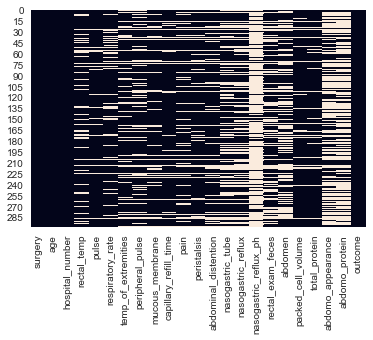

In [4]:
# Visualizing null values
sns.heatmap(horses_clean.isnull(), cbar=False)
plt.show()

The `nasogastric` columns refer to the results of a nasogastric intubation, where a tube is inserted into the horse's nose and pushed into the stomach. Once the tube enters the stomach, gas and stomach acid may come through the tube, and the quantity of both are noted as part of diagnosis. 

The quantity of null values may indicate that the pH of nasogastric reflux was rarely measured, so this column is dropped. 

Horses with null values for all three columns likely did not have the procedure done at all, so this can be represented with a new column. 

There are also horses who have null values for one of the two nasogastric columns. For these, we can assume there was nothing noteworthy for the null features, and replace them with 'none'.

In [5]:
# Removing nasogastric_reflux_ph
horses_clean = horses_clean.drop('nasogastric_reflux_ph', axis=1)

# Creating new nasogastric_done column, adjusting null values to n_a
horses_clean['nasogastric_done'] = 1
no_tube = (horses_clean['nasogastric_tube'].isnull()) & (horses_clean['nasogastric_reflux'].isnull())
horses_clean.loc[no_tube, 'nasogastric_done'] = 0
horses_clean.loc[no_tube, 'nasogastric_tube'] = 'n_a'
horses_clean.loc[no_tube, 'nasogastric_reflux'] = 'n_a'

# Remaining nulls indicate none
horses_clean['nasogastric_tube'].fillna('none', inplace=True)
horses_clean['nasogastric_reflux'].fillna('none', inplace=True)

The `abdomo_appearance` and `abdomo_protein` columns refer to a specific procedure - abdominocentesis. During this procedure, a needle is inserted into the horse's abdomen and fluid is collected. The appearance column refers to the appearance of the fluid, and the protein column refers to the amount of protein in the fluid, with higher numbers corresponding to a higher probability of having a compromised gut. More than half of the horses in the data have null values for these columns, indicating most horses did not undergo this procedure so these columns will be dropped.

In [6]:
horses_clean = horses_clean.drop(['abdomo_appearance','abdomo_protein'], axis=1)

##### Rows with high null counts

The heatmap shows that there are rows with many null values, represented by the long horizontal lines. These rows don't contain much information, so instead of filling them all with placeholder data that might skew results, they should be removed.

Currently, the maximum number of null values a row can have is 14. However, this data set is fairly small with 299 entries. The more rows removed, the less data to train the model on.

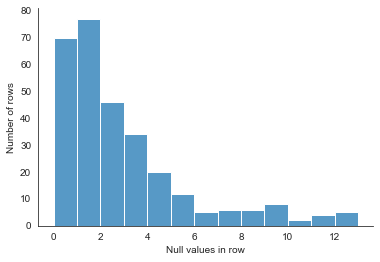

In [7]:
# Counting number of null values in each row
rownull_counts = horses_clean.isnull().sum(axis=1).to_frame()
horses_clean['rownull_counts'] = rownull_counts

# Visualizing distribution of null counts per row
sns.histplot(data=horses_clean, x='rownull_counts', bins=range(0,14,1), multiple='stack')
sns.despine()
plt.xlabel('Null values in row')
plt.ylabel('Number of rows')
plt.show()

Looking at the histogram of null value counts by row, putting the cutoff at 5 null values seems like a starting point.

In [8]:
horses_clean = horses_clean[horses_clean['rownull_counts'] < 5]
print('Rows remaining:', horses_clean.shape[0])

Rows remaining: 247


For the remaining null values, the non-null values can be analyzed to fill in the missing ones with reasonable values.

##### Duplicate rows

It is worth noting that `hospital_id` is unique for each horse, not each visit. Therefore, horses that visit the clinic multiple times will appear multiple times in the data set. 

In [9]:
## How many horses were treated more than once? ##
unique_ids = []
multiples = []

for index, row in horses_clean.iterrows():
    num = row['hospital_number']
    if num not in unique_ids:
        unique_ids.append(num)
    elif num in unique_ids and num not in multiples:
        multiples.append(num)
print('Horses with multiple visits:', len(multiples))

Horses with multiple visits: 15


In [10]:
# Review horses with multiple visits
frequent_fliers = horses_clean[horses_clean['hospital_number'].isin(multiples)].sort_values('hospital_number')
frequent_fliers

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,outcome,nasogastric_done,rownull_counts
281,yes,adult,527544,NaN,70.0,16.0,cool,absent,bright_red,more_3_sec,depressed,hypomotile,slight,slight,none,absent,distend_large,60.0,7.5,died,1,1
110,yes,adult,527544,NaN,70.0,16.0,cool,absent,bright_red,more_3_sec,depressed,hypomotile,slight,slight,none,absent,distend_large,60.0,7.5,died,1,1
178,no,adult,528151,38.5,100.0,NaN,cool,reduced,bright_red,more_3_sec,severe_pain,hypomotile,severe,slight,none,absent,distend_large,NaN,NaN,euthanized,1,3
204,no,adult,528151,38.5,100.0,NaN,cool,reduced,bright_red,more_3_sec,severe_pain,hypomotile,severe,slight,none,absent,distend_large,NaN,NaN,euthanized,1,3
234,yes,adult,528469,38.1,52.0,24.0,normal,normal,bright_red,less_3_sec,severe_pain,hypomotile,none,slight,more_1_liter,normal,NaN,54.0,7.5,died,1,1
73,yes,adult,528469,38.1,52.0,24.0,normal,normal,bright_red,less_3_sec,severe_pain,hypomotile,none,slight,more_1_liter,normal,NaN,54.0,7.5,died,1,1
233,no,adult,528729,37.5,48.0,30.0,cold,normal,pale_pink,less_3_sec,NaN,normal,none,none,none,normal,normal,48.0,8.6,lived,1,1
94,no,adult,528729,37.5,48.0,30.0,cold,normal,pale_pink,less_3_sec,NaN,normal,none,none,none,normal,normal,48.0,8.6,lived,1,1
290,yes,adult,528890,38.9,80.0,44.0,cool,reduced,pale_pink,less_3_sec,depressed,hypomotile,moderate,slight,less_1_liter,decreased,normal,54.0,6.5,died,1,0
48,yes,adult,528890,38.9,80.0,44.0,cool,reduced,pale_pink,more_3_sec,depressed,hypomotile,moderate,slight,less_1_liter,decreased,normal,54.0,6.5,died,1,0


Clearly, there are duplicate entries for some of these horses - the same horse can't die twice. These duplicates are explained by the rows differing in the `lesion_1` column, where instead of multiple lesions going into the next columns, they were entered in a new row. The duplicates should be dropped.

In [11]:
horses_clean = horses_clean.drop_duplicates()

##### Categorical variables

Now, the categorical columns will be cleaned. These columns include:
* `surgery`
* `age`
* `temp_of_extremities`
* `peripheral_pulse`
* `mucous_membrane`
* `capillary_refill_time`
* `pain`
* `peristalsis`
* `abdominal_distention`
* `rectal_exam_feces`
* `abdomen`
* `outcome`

In [12]:
# Summarizing categorical column value frequencies and null counts
cat_cols = ['surgery','age','temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time','pain',
            'peristalsis','abdominal_distention','rectal_exam_feces','abdomen','outcome']
for col in cat_cols:
    print(col.upper())
    print('% rows null: ', sum(horses_clean[col].isnull())/len(horses_clean)*100)
    print(horses_clean[col].value_counts(normalize=True)*100, '\n')

SURGERY
% rows null:  0.0
yes    58.158996
no     41.841004
Name: surgery, dtype: float64 

AGE
% rows null:  0.0
adult    93.305439
young     6.694561
Name: age, dtype: float64 

TEMP_OF_EXTREMITIES
% rows null:  7.112970711297072
cool      44.144144
normal    32.432432
warm      13.063063
cold      10.360360
Name: temp_of_extremities, dtype: float64 

PERIPHERAL_PULSE
% rows null:  11.715481171548117
normal       51.658768
reduced      44.075829
absent        2.369668
increased     1.895735
Name: peripheral_pulse, dtype: float64 

MUCOUS_MEMBRANE
% rows null:  4.184100418410042
normal_pink      32.314410
pale_pink        22.707424
pale_cyanotic    16.157205
bright_pink      12.663755
bright_red        9.170306
dark_cyanotic     6.986900
Name: mucous_membrane, dtype: float64 

CAPILLARY_REFILL_TIME
% rows null:  2.510460251046025
less_3_sec    71.244635
more_3_sec    27.896996
3              0.858369
Name: capillary_refill_time, dtype: float64 

PAIN
% rows null:  6.694560669456067
mi

`capillary_refill_time` includes some values that are 3. According to the data dictionary, refill times equal to 3 are part of the more than 3 category, so these will be adjusted. Additionally, since the less than 3 sec category is by far the most common, null values will be replaced with this.

In [13]:
# Clean capillary_refill_time values of 3 and fill null values
horses_clean.loc[horses_clean['capillary_refill_time'] == '3', 'capillary_refill_time'] = 'more_3_sec'
horses_clean['capillary_refill_time'].fillna('less_3_sec', inplace=True)

The `abdominal_distention` and `pain` categories are pretty evenly spread, and upon examination there are no linear relationships to try and predict these values. Columns `ab_dis_rank` and `pain` were created to represent categorical levels as integers. The null rows will be dropped.

Additionally, 30% of the `abdomen` rows and 24% of the `rectal_exam_feces` rows are null, so these columns will be dropped.

In [14]:
# Convert ordered rank categories into integers
pain_dict = {'alert':0, 'depressed':1, 'mild_pain':2, 'severe_pain':3, 'extreme_pain':4}
abdis_dict = {'none':0, 'slight':1, 'moderate':2, 'severe':3}

horses_clean['pain_rank'] = horses_clean['pain'].map(pain_dict)
horses_clean['ab_dis_rank'] = horses_clean['abdominal_distention'].map(abdis_dict)

In [15]:
# Drop original category columns and additional high-null columns
horses_clean.dropna(subset=['abdominal_distention', 'pain'], inplace=True)
horses_clean.drop(['abdomen', 'rectal_exam_feces'], axis=1, inplace=True)

The remaining columns will have their null values filled with the mode.

In [16]:
# Replace null values of remaining categorical columns with mode
mode_cols = ['temp_of_extremities','peripheral_pulse','mucous_membrane','peristalsis']
for col in mode_cols:
    horses_clean.loc[horses_clean[col].isnull(), col] = horses_clean[col].mode().iloc[0]

##### Numerical columns

The remaining numerical columns are `rectal_temp`, `pulse`, `respiratory_rate`, `packed_cell_volume`, and `total_protein`.

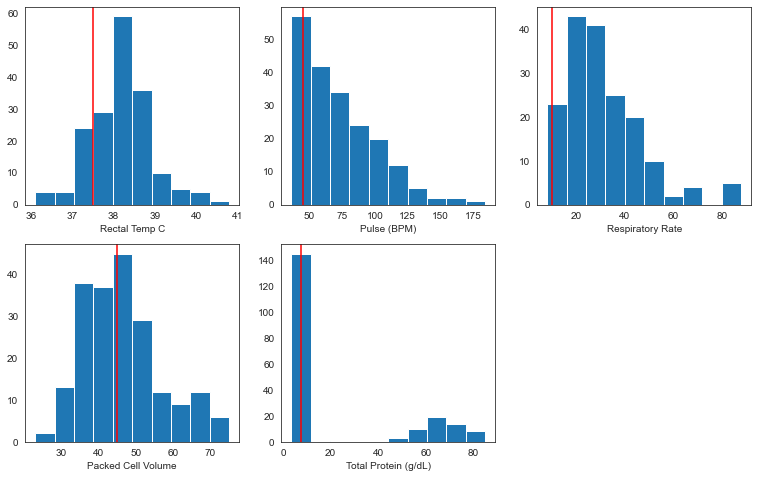

In [17]:
# Plotting distributions of numerical values and the expected value for a healthy horse as a vertical line
plt.figure(figsize=(13,8))
plt.subplot(2,3,1)
plt.hist(horses_clean['rectal_temp'])
plt.xlabel('Rectal Temp C')
plt.axvline(37.5, 0, 90, color='red')

plt.subplot(2,3,2)
plt.hist(horses_clean['pulse'])
plt.xlabel('Pulse (BPM)')
plt.axvline(45, 0, 80, color='red')

plt.subplot(2,3,3)
plt.hist(horses_clean['respiratory_rate'])
plt.xlabel('Respiratory Rate')
plt.axvline(10, 0, 70, color='red')

plt.subplot(2,3,4)
plt.hist(horses_clean['packed_cell_volume'])
plt.xlabel('Packed Cell Volume')
plt.axvline(45, 0, 60, color='red')

plt.subplot(2,3,5)
plt.hist(horses_clean['total_protein'])
plt.xlabel('Total Protein (g/dL)')
plt.axvline(7.5, 0, 30, color='red')
plt.show()

The red lines in the above plots represent the normal values for each test. Most horses had an elevated `rectal_temp`, and since the distribution is fairly normal, the mean can be used as a replacement metric. `packed_cell_volume` is also roughly normally distributed, and the mean is near the normal value. `pulse` and `respiratory_rate` are right-skewed, so the mode will be used for them. However, while the majority of horses have `total_protein` counts in the normal range, there is a subset with much higher levels. Correlations between protein counts and other variables were analyzed but none were identified, so these values will be replaced with the median.

In [19]:
horses_clean['rectal_temp'].fillna(horses_clean['rectal_temp'].mean(), inplace=True)
horses_clean['packed_cell_volume'].fillna(horses_clean['packed_cell_volume'].mean(), inplace=True)

horses_clean['pulse'].fillna(40, inplace=True)
horses_clean['respiratory_rate'].fillna(horses_clean['respiratory_rate'].median(), inplace=True) # median is close to mode

horses_clean['total_protein'].fillna(horses_clean['total_protein'].median(), inplace=True)

In [20]:
print(horses_clean.isna().sum())

surgery                  0
age                      0
hospital_number          0
rectal_temp              0
pulse                    0
respiratory_rate         0
temp_of_extremities      0
peripheral_pulse         0
mucous_membrane          0
capillary_refill_time    0
pain                     0
peristalsis              0
abdominal_distention     0
nasogastric_tube         0
nasogastric_reflux       0
packed_cell_volume       0
total_protein            0
outcome                  0
nasogastric_done         0
rownull_counts           0
pain_rank                0
ab_dis_rank              0
dtype: int64


Now that the data has been cleaned, the `rownull_counts` column will be dropped since it isn't necessary and the data will be exported.

In [21]:
horses_clean.drop('rownull_counts', axis=1, inplace=True)

In [22]:
horses_clean.to_csv('horses_clean.csv')